Error parsing GML data: edge #12757 (1047->1179) is duplicated
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 11), (2, 3), (2, 11), (3, 11), (10, 11), (11, 12), (11, 13), (11, 14), (11, 15), (11, 23), (11, 24), (11, 25), (11, 26), (11, 27), (11, 28), (11, 29), (11, 31), (11, 32), (11, 33), (11, 34), (11, 35), (11, 36), (11, 37), (11, 38), (11, 43), (11, 44), (11, 48), (11, 49), (11, 51), (11, 55), (11, 58), (11, 64), (11, 68), (11, 69), (11, 70), (11, 71), (11, 72), (12, 23), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 26), (16, 55), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (18, 19), (18, 20), (18, 21), (18, 22), 

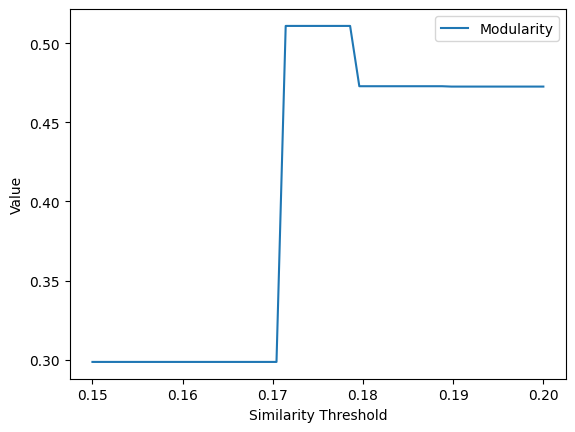

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.cluster import normalized_mutual_info_score
import urllib.request
import io
import zipfile
import copy

def merge_small_communities(G, initial_communities, lambda_threshold=3):
    # Step 1: Classify communities based on size
    small_communities = [set(c) for c in initial_communities if len(c) < lambda_threshold]
    large_communities = [set(c) for c in initial_communities if len(c) >= lambda_threshold]

    # Initialize a list to store nodes from small communities without neighbors in large communities
    unassigned_nodes = []

    # For each small community, find the best large community to merge into
    for small_community in small_communities:
        best_total_similarity = 0
        best_large_community_index = None

        # Calculate total similarity of each small community node with nodes in each large community
        for i, large_community in enumerate(large_communities):
            total_similarity = 0
            for node in small_community:
                has_neighbor_in_large_community = any(neighbor in large_community for neighbor in G.neighbors(node))
                if has_neighbor_in_large_community:
                    n_u = set(G.neighbors(node)) | {node}
                    for neighbor in G.neighbors(node):
                        if neighbor in large_community:
                            n_v = set(G.neighbors(neighbor)) | {neighbor}
                            intersection = len(n_u & n_v)
                            union = len(n_u | n_v)
                            similarity = float(intersection) / union if union != 0 else 0
                            total_similarity += similarity

            # Update the best large community based on total similarity
            if total_similarity > best_total_similarity:
                best_total_similarity = total_similarity
                best_large_community_index = i

        # If no neighbors in large community, add the node to unassigned list
        if best_large_community_index is None:
            unassigned_nodes.extend(small_community)
        else:
            # Merge the small community into the best matching large community
            large_communities[best_large_community_index] = large_communities[best_large_community_index].union(small_community)

    # Reevaluate unassigned nodes with updated large communities
    for node in unassigned_nodes:
        best_total_similarity = 0
        best_large_community_index = None

        for i, large_community in enumerate(large_communities):
            total_similarity = 0
            for neighbor in G.neighbors(node):
                if neighbor in large_community:
                    n_u = set(G.neighbors(node)) | {node}
                    n_v = set(G.neighbors(neighbor)) | {neighbor}
                    intersection = len(n_u & n_v)
                    union = len(n_u | n_v)
                    similarity = float(intersection) / union if union != 0 else 0
                    total_similarity += similarity

            # Update the best large community based on total similarity
            if total_similarity > best_total_similarity:
                best_total_similarity = total_similarity
                best_large_community_index = i

        # Merge the unassigned node into the best matching large community
        if best_large_community_index is not None:
            large_communities[best_large_community_index].add(node)

    # Combine all communities after merging
    final_communities = large_communities + [list(c) for c in small_communities if len(c) >= lambda_threshold]

    return final_communities


    # Reevaluate unassigned nodes with updated large communities
    for node in unassigned_nodes:
        best_total_similarity = 0
        best_large_community_index = None

        for i, large_community in enumerate(large_communities):
            total_similarity = 0
            for neighbor in G.neighbors(node):
                if neighbor in large_community:
                    n_u = set(G.neighbors(node)) | {node}
                    n_v = set(G.neighbors(neighbor)) | {neighbor}
                    intersection = len(n_u & n_v)
                    union = len(n_u | n_v)
                    similarity = float(intersection) / union if union != 0 else 0
                    total_similarity += similarity

            # Update the best large community based on total similarity
            if total_similarity > best_total_similarity:
                best_total_similarity = total_similarity
                best_large_community_index = i

        # Merge the unassigned node into the best matching large community
        if best_large_community_index is not None:
            large_communities[best_large_community_index].add(node)

    # Combine all communities after merging
    final_communities = large_communities + [list(c) for c in small_communities if len(c) >= lambda_threshold]

    return final_communities

def find_most_similar_node_pairs_iterative(similarity_matrix):
    current_similarity_matrix = copy.deepcopy(similarity_matrix)
    num_nodes = current_similarity_matrix.shape[0]

    # Initialize a dictionary to store results based on similarity values
    similar_pairs_dict = {}
    s = set()
    while (len(s) < num_nodes):
        # Find the indices of the maximum similarity value in the entire matrix
        i, j = np.unravel_index(np.argmax(current_similarity_matrix, axis=None), current_similarity_matrix.shape)
        similar_pair = (i, j)
        s.add(i)
        s.add(j)
        similar_value = current_similarity_matrix[i, j]

        # Exclude the current pair by setting its similarity to -inf
        current_similarity_matrix[i, j] = -np.inf

        # Append the result to the dictionary based on similarity value
        if similar_value not in similar_pairs_dict:
            similar_pairs_dict[similar_value] = []

        similar_pairs_dict[similar_value].append(similar_pair)

    # # # Print and return the results
    # for value, pairs in similar_pairs_dict.items():
    #     for idx, pair in enumerate(pairs):
    #          print(f"Similar Pair with Value {value}, Index {idx + 1}: {pair}")

    return similar_pairs_dict





def form_initial_communities(result_matrix, lambda_threshold=2, similarity_threshold=0.15):
    num_nodes = result_matrix.shape[0]
    communities = [[node] for node in range(num_nodes)]  # Initially, each node is in its own community

    # Create a new similarity matrix with updated values
    updated_similarity_matrix = result_matrix.copy()
    for i in range(num_nodes):
        for j in range(i+1,num_nodes):  # Consider upper triangular matrix to avoid repetition
            if result_matrix[i, j] < similarity_threshold:
                updated_similarity_matrix[i, j] = 0
                updated_similarity_matrix[j, i] = 0

    # Print the new similarity matrix
    # print("New Similarity Matrix:")
    # for row in updated_similarity_matrix:
    #     print(list(row))

    while True:
        # Find the pair of communities with the highest average similarity score
        max_avg_similarity = 0
        max_community_pair = None

        for i in range(len(communities)):
            for j in range(i + 1, len(communities)):
                community_i = communities[i]
                community_j = communities[j]

                total_similarity = 0
                num_nodes_i = len(community_i)

                for u in community_i:
                    node_similarity_sum = sum(updated_similarity_matrix[u, v] for v in community_j)
                    node_avg_similarity = node_similarity_sum / len(community_j)
                    total_similarity += node_avg_similarity
                total_similarity /= num_nodes_i

                if total_similarity > max_avg_similarity:
                    max_avg_similarity = total_similarity
                    max_community_pair = (i, j)


        if max_community_pair is None:
            break  # No more communities to merge

        if max_avg_similarity < similarity_threshold:
                    break
        # Merge the communities with the highest average similarity score
        i, j = max_community_pair
        merged_community = communities[i] + communities[j]
        communities.pop(j)
        communities.pop(i)
        communities.append(merged_community)

        # Check if all remaining communities have at least the specified threshold
        if min(len(community) for community in communities) >= lambda_threshold:
            break

    return communities


def matrix_operation(A, S, G):  # Assuming G is your graph
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    n = num_edges / num_nodes  # Calculate n as the number of nodes divided by the number of edges

    # Calculate S^n
    S_power_n = np.linalg.matrix_power(S, int(n))

    # Perform A * S^n
    result = np.dot(A, S_power_n)

    return result


def normalized_coefficients(jaccard_matrix):
    # Initialize an empty matrix of the same shape as the jaccard_matrix
    normalized_matrix = np.zeros(jaccard_matrix.shape)

    # Iterate over each row in the jaccard_matrix
    for i in range(jaccard_matrix.shape[0]):
        row_sum = np.sum(jaccard_matrix[i, :])  # Calculate the sum of the current row
        if row_sum > 0:  # Avoid division by zero'
            normalized_matrix[i, :] = jaccard_matrix[i, :] / row_sum
            nsum = np.sum(normalized_matrix[i, :])  # Normalize the row by its sum
    # checks if the sum of each row is 1
    # for i in range(normalized_matrix.shape[0]):
    #     row_sum = np.sum(normalized_matrix[i, :])
    #     print(f"Sum of row {i}: {row_sum}")
    print("---------------------Normalized Jaccard Matrix------------------")
    print(normalized_matrix)
    return normalized_matrix


def get_jaccard_coefficients(G):
    num_nodes = G.number_of_nodes()
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for u in range(num_nodes):
        for v in range(num_nodes):
            if u != v:  # Ensure we're not comparing a node with itself
                n_u = set(G[u])  # Neighbors of u
                n_v = set(G[v])  # Neighbors of v
                intersection = len(n_u & n_v)
                union = len(n_u | n_v)
                adjacency_matrix[u, v] = float(intersection) / (union) if union != 0 else 0
    print("-----------------Jaccard Matrix---------------")
    print(adjacency_matrix)
    return adjacency_matrix


def get_adjacency_matrix(G):
    num_nodes = G.number_of_nodes()
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # Fill the adjacency matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            if G.has_edge(i, j):
                adjacency_matrix[i, j] = 1
            else:
                adjacency_matrix[i, j] = 0
    print("--------------------Adjacency Matrix------------------")
    print(adjacency_matrix)
    return adjacency_matrix

    # Download and extract the dolphin dataset
url = "http://www-personal.umich.edu/~mejn/netdata/polblogs.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("polblogs.txt").decode()  # read info file
gml = zf.read("polblogs.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
try:
    G = nx.parse_gml(gml)  # parse gml data
except nx.NetworkXError as e:
    print("Error parsing GML data:", e)
    # Handle the error gracefully, such as skipping the duplicate edges or logging them




# Convert node labels to integers
mapping = dict(zip(G.nodes(), range(len(G.nodes()))))
G = nx.relabel_nodes(G, mapping)

print(G.nodes())
print(G.edges())








Adjancency = get_adjacency_matrix(G)
jaccard_coefficients = get_jaccard_coefficients(G)
jaccard_normalized = normalized_coefficients(jaccard_coefficients)
# print(A)
print(jaccard_coefficients)
print(jaccard_normalized)
# Optionally, print the Jaccard coefficients
markov_similarity_enhancement_matrix = matrix_operation(Adjancency, jaccard_normalized, G)
print(markov_similarity_enhancement_matrix)
result_list = find_most_similar_node_pairs_iterative(markov_similarity_enhancement_matrix)

initial_communities = form_initial_communities(markov_similarity_enhancement_matrix,lambda_threshold=2,  similarity_threshold=0.18)
final_communities = merge_small_communities(G, initial_communities,lambda_threshold=2)

print("----------------------------Initial Community----------------------------------")
for i, community in enumerate(initial_communities):
    print(f"Community {i + 1}: {community}")

print("-----------------------------Final Community-----------------------------------")
for i, community in enumerate(final_communities):
    print(f"Final Community {i + 1}: {community}")


# def create_sets_based_on_membership(G, football_truth):
#     membership_sets = {}  # Dictionary to store sets of nodes for each ground truth membership

#     for node, membership in enumerate(football_truth):
#         if membership not in membership_sets:
#             membership_sets[membership] = set()

#         membership_sets[membership].add(node)

#     return membership_sets

# # # Create sets based on ground truth membership
# membership_sets = create_sets_based_on_membership(G, football_truth)

# print("------------------------Sets based on Ground Truth Membership-------------------")
# for membership, node_set in membership_sets.items():
#      print(f"Ground Truth Membership: {membership}, Nodes: {node_set}")


print("Modularity",nx.community.quality.modularity(G, final_communities))

num_nodes = G.number_of_nodes()


# predicted_labels = np.zeros(num_nodes, dtype=int)
# for idx, community in enumerate(final_communities):
#     for node in community:
#         predicted_labels[node] = idx
# print("Predicted Labels:", predicted_labels)
# print(football_truth)
# nmi_score_binary_matrix = normalized_mutual_info_score(football_truth, predicted_labels)

# print("NMI Score", nmi_score_binary_matrix)

def plot_communities(G, communities, title):
    # Manually define a list of colors for the communities
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf","#00b2fe","#39D2C0"
    ]
    # This list can be extended with more colors if needed

    # Assign a color to each community, grey for communities of size 1
    community_colors = {}
    for i, community in enumerate(communities):
        for node in community:
            if len(community) == 1:
                community_colors[node] = "grey"  # Grey color for communities of size 1
            else:
                # Use modulo to cycle through the color list if there are more communities than colors
                community_colors[node] = colors[i % len(colors)]

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # positions for all nodes

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=[community_colors[node] for node in G.nodes()], node_size=50)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes()}, font_size=12)
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title(title)
    plt.axis('off')
    plt.show()

# Find the index of the maximum modularity and NMI values



similarity_thresholds = np.linspace(0.15, 0.2, 50)  # Adjust range and steps as needed
modularity_values = []


Adjacency = get_adjacency_matrix(G)
jaccard_coefficients = get_jaccard_coefficients(G)
jaccard_normalized = normalized_coefficients(jaccard_coefficients)

# Iterate over similarity thresholds
for similarity_threshold in similarity_thresholds:
    # Enhance similarity matrix and find communities

    markov_similarity_enhancement_matrix = matrix_operation(Adjacency, jaccard_normalized, G)
    initial_communities = form_initial_communities(markov_similarity_enhancement_matrix, lambda_threshold=2, similarity_threshold=similarity_threshold)
    final_communities = merge_small_communities(G, initial_communities, lambda_threshold=3)

    # Calculate modularity
    modularity = nx.community.quality.modularity(G, final_communities)
    modularity_values.append(modularity)

max_modularity_index = np.argmax(modularity_values)
# max_nmi_index = np.argmax(nmi_values)

# Corresponding similarity thresholds
similarity_threshold_with_max_modularity = similarity_thresholds[max_modularity_index]
# similarity_threshold_with_max_nmi = similarity_thresholds[max_nmi_index]

# # Maximum modularity and NMI values
max_modularity = modularity_values[max_modularity_index]
# max_nmi = nmi_values[max_nmi_index]

print("Maximum Modularity:")
print("Similarity Threshold:", similarity_threshold_with_max_modularity)
print("Modularity:", max_modularity)

# print("\nMaximum NMI:")
# print("Similarity Threshold:", similarity_threshold_with_max_nmi)
# print("NMI:", max_nmi)

# Plot both Modularity and NMI values against similarity thresholds
plt.plot(similarity_thresholds, modularity_values, label='Modularity')
# plt.plot(similarity_thresholds, nmi_values, label='NMI')
# plt.title('Modularity and NMI vs Similarity Threshold')
plt.xlabel('Similarity Threshold')
plt.ylabel('Value')
plt.legend()
plt.show()